In [8]:
!pip install wordcloud

from datasets import load_from_disk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import os
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/imenbenammar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/imenbenammar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Defining functions to use

def load_full_dataset(dataset_path):
    """
    Loads the dataset from the specified path, combines the train, validation, and test splits into a single DataFrame, 
    shuffles the data, and returns the full dataset.
    
    Input:
    - dataset_path (str): Path to the dataset.
    Output:
    - full_df (pd.DataFrame): The concatenated and shuffled DataFrame containing the full dataset.
    """
    dataset = load_from_disk(dataset_path)
    # convert the train, validation, and test splits to a pd dataframe
    train_df = dataset['train'].to_pandas()
    test_df = dataset['test'].to_pandas()
    validation_df = dataset['validation'].to_pandas()   
    full_df = pd.concat([train_df, validation_df, test_df], ignore_index=True)
    # shuffle
    full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)
    return full_df
    
def display_dataset_info(df):
    """
    Displays dataset info and the first 5 rows.
    
    Input:
    - df (pd.DataFrame): The dataset.
    
    Output:
    - Prints dataset info and first 5 rows.
    """

    print("Dataset info: ")
    df.info()
    print("----------------------------------------------------------------")
    # display the first 5 rows of the dataset
    print("\n First 5 rows of the dataset: ")
    print(df.head())
    print("----------------------------------------------------------------")

def count_nulls(df):
    """
    Counts and returns null values per column.
    
    Input:
    - df (pd.DataFrame): The dataset.
    
    Output:
    - null_counts (pd.Series): Count of nulls per column.
    """
    null_counts = df.isnull().sum()
    return null_counts

def clean_and_tokenize(text, stop_words):
    """
    Cleans and tokenizes text, removing non-alphanumeric characters and stopwords.
    
    Input:
    - text (str): The text to clean and tokenize.
    - stop_words (list): List of stopwords.
    
    Output:
    - filtered_tokens (list): List of cleaned tokens.
    """
    text = re.sub(r'[^A-Za-z0-9\s]', '', text.lower())
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

In [10]:
# define functions for datasets 1 and 2 

def plot_toxicity_subtype_frequency(df, dataset=None, outfile=None, folder_path='plots/'):
    """
    Plots the frequency of non-zero values for each toxicity subtype column in the dataset.
    
    Input:
    - df (pd.DataFrame): The dataset containing toxicity columns.
    - dataset (str): Name of the dataset ('Jigsaw' or 'civil_comments') to select the correct text column.
    - outfile (str, optional): Path to save the plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays a bar plot of the frequencies of non-zero values for each toxicity subtype.
    """
    if dataset == 'Jigsaw':
        toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    elif dataset == 'civil_comments':
        toxicity_columns = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
    
    # list to store the frequency of non-zero values for each column
    frequencies = []
    # counting non zero values in each toxicity column
    for col in toxicity_columns:
        non_zero_count = (df[col] > 0).sum() 
        frequencies.append(non_zero_count)

    # plot 
    plt.figure(figsize=(7, 4))
    sns.barplot(x=toxicity_columns, y=frequencies, palette="viridis")
    plt.title('Frequency of Each Toxicity Subtype')
    plt.xlabel('Toxicity Subtype')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid()
    # save the plot if outfile is provided
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Visualization saved to {outfile}")
    plt.show()
    


def plot_toxicity_percentage(df, dataset=None, outfile=None, folder_path='plots/'):
    """
    Plots the percentage of toxic and non-toxic comments based on the specified toxicity labels.
    
    Input:
    - df (pd.DataFrame): The dataset containing toxicity labels.
    - dataset (str): Name of the dataset ('Jigsaw' or 'civil_comments') to select the correct text column.
    - outfile (str, optional): Path to save the plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays a pie chart showing the percentage of toxic and non-toxic comments.
    """
    if dataset == 'Jigsaw':
        toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    elif dataset == 'civil_comments':
        toxicity_labels = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
        
    # check if any toxicity label is set for each row
    df['is_toxic'] = df[toxicity_labels].sum(axis=1) > 0  
    # count the number of toxic and non-toxic comments
    toxicity_counts = df['is_toxic'].value_counts()
    
    # prepare data for the pie chart
    labels = ['Non-Toxic', 'Toxic']
    sizes = [toxicity_counts.get(False, 0), toxicity_counts.get(True, 0)]
    explode = (0.1, 0) 
    # plot
    plt.figure(figsize=(7, 4))
    plt.pie(sizes, explode=explode, labels=labels, colors=['#3b528b', '#5ec962'], autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('Percentage of Toxic and Non-Toxic Comments')
    plt.axis('equal') 
    # save the plot if outfile is provided
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Visualization saved to {outfile}")
    plt.show()


def plot_wordclouds(df, dataset=None, outfile=None, folder_path='plots/'):
    """
    Generates and displays word clouds for toxic and non-toxic comments.
    
    Input:
    - df (pd.DataFrame): The dataset containing the comments and toxicity labels.
    - dataset (str): Name of the dataset ('Jigsaw' or 'civil_comments').
    - outfile (str, optional): Path to save the plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays two word clouds, one for toxic and one for non-toxic comments.
    """
    if dataset == 'Jigsaw':
        toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    elif dataset == 'civil_comments':
        toxicity_labels = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
        
    # create a new column 'is_toxic' and set it to true if one toxicity subtype is present
    df['is_toxic'] = df[toxicity_labels].sum(axis=1) > 0
    # set column name for text
    if (dataset == 'Jigsaw'):
        text_col = 'comment_text'
    elif (dataset == 'civil_comments'):
        text_col = 'text'
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
    # separate toxic and non-toxic comments
    toxic = ' '.join(df[df['is_toxic']][text_col])
    non_toxic = ' '.join(df[~df['is_toxic']][text_col])
    
    # generate wordclouds
    toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds', max_words=100).generate(toxic)
    non_toxic_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens', max_words=100).generate(non_toxic)
    # plot
    plt.figure(figsize=(14, 7))
    # toxic comments word cloud
    plt.subplot(1, 2, 1)
    plt.title('Word Cloud of Toxic Comments', fontsize=16)
    plt.imshow(toxic_wordcloud, interpolation='bilinear')
    plt.axis('off')
    # non-toxic comments word cloud
    plt.subplot(1, 2, 2)
    plt.title('Word Cloud of Non-Toxic Comments', fontsize=16)
    plt.imshow(non_toxic_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    # save the plot if outfile is provided
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Visualization saved to {outfile}")
    plt.show()


def analyze_comment_len(df, dataset=None, outfile=None, folder_path='plots/'):
    """
    Analyzes comment lengths and compares them between toxic and non-toxic comments.
    
    Input:
    - df (pd.DataFrame): Dataset containing comments and toxicity labels.
    - dataset (str): Dataset name ('Jigsaw' or 'civil_comments').
    - outfile (str, optional): Path to save the combined plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays statistics and saves plots to a single image if outfile is provided.
    """
    if dataset == 'Jigsaw':
        toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        text_col = 'comment_text'
    elif dataset == 'civil_comments':
        toxicity_labels = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
        text_col = 'text'
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
    
    # create new column and calculate comment lengths
    df['comment_length'] = df[text_col].apply(len)
    # display basic statistics of comment lengths
    print("Basic Statistics for Comment Lengths:")
    print(df['comment_length'].describe())
    print("\n")
    
    df['is_toxic'] = df[toxicity_labels].sum(axis=1) > 0
    
    # figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), constrained_layout=True)
    
    # distribution of comment lengths
    sns.histplot(df['comment_length'], bins=20, kde=True, color='#21918c', ax=axes[0])
    axes[0].set_title('Distribution of Comment Lengths')
    axes[0].set_xlabel('Comment Length')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)
    
    # comment lengths between toxic and non-toxic
    sns.boxplot(data=df, x='is_toxic', y='comment_length', palette='viridis', ax=axes[1])
    axes[1].set_title('Comment Length Comparison: Toxic vs. Non-Toxic')
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(['Non-Toxic', 'Toxic'])
    axes[1].set_xlabel('Comment Type')
    axes[1].set_ylabel('Comment Length')
    axes[1].grid(True)
    
    # average comment length for toxic and non toxic
    toxicity_avg_length = df.groupby('is_toxic')['comment_length'].mean().reset_index()
    sns.barplot(data=toxicity_avg_length, x='is_toxic', y='comment_length', palette='viridis', ax=axes[2])
    axes[2].set_title('Average Comment Length: Toxic vs. Non-Toxic')
    axes[2].set_xticks([0, 1])
    axes[2].set_xticklabels(['Non-Toxic', 'Toxic'])
    axes[2].set_xlabel('Comment Type')
    axes[2].set_ylabel('Average Comment Length')
    axes[2].grid(True)
    
    # save the figure to outfile if provided
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Plots saved to {outfile}")
    plt.show()


def plot_word_frequency(df, dataset=None, outfile=None, folder_path='plots/', threshold=0.8, top_n=10):
    """
    Plots the most common words (top N) in toxic comments for each toxicity label above a specified threshold.
    
    Input:
    - df (pd.DataFrame): Dataset containing comments and toxicity labels.
    - dataset (str): Name of the dataset ('Jigsaw' or 'civil_comments') to select the correct text column.
    - threshold (float, optional): Minimum toxicity level to consider a comment as toxic (default is 0.8).
    - top_n (int, optional): Number of most common words to display (default is 10).
    - outfile (str, optional): Path to save the plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays bar plots for the most common words in toxic comments for each label.
    """
    
    if dataset == 'Jigsaw':
        toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        # set column name for text
        text_col = 'comment_text'
    elif dataset == 'civil_comments':
        toxicity_labels = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
        text_col = 'text'
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
    
    # define stop words
    stop_words = set(stopwords.words('english'))
    
    n_labels = len(toxicity_labels)
    # subplots
    fig, axes = plt.subplots(n_labels, 1, figsize=(7, 4 * n_labels), constrained_layout=True)
    if n_labels == 1:
        axes = [axes]
    
    # loop through each toxicity label
    for i, label in enumerate(toxicity_labels):
        # filter rows where the toxicity value for the label is higher than the threshold
        is_toxic = df[label] > threshold
        toxic_comments = df[is_toxic][text_col]
        
        # tokenize and clean all comments
        all_tokens = []
        for comment in toxic_comments:
            all_tokens.extend(clean_and_tokenize(comment, stop_words))
        
        # frequency of each word
        word_counts = Counter(all_tokens)
        # select top_n most common words
        common_words = word_counts.most_common(top_n)
        
        # plot if common words are found
        if common_words:
            words, counts = zip(*common_words)
            sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[i])
            axes[i].set_title(f'Most Common Words for {label.capitalize()} (Threshold > {threshold})')
            axes[i].set_xlabel('Frequency')
            axes[i].set_ylabel('Words')
            axes[i].grid(True)
        else:
            axes[i].set_title(f'No words found for {label.capitalize()} with threshold > {threshold}')
            axes[i].axis('off')  # hide the axis
    
    # save the figure to outfile if provided
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Plot saved to {outfile}")
    
    plt.show()


def plot_toxicity_vs_comment_length(df, dataset=None, outfile=None, folder_path='plots/'):
    """
    Plots scatter plots comparing comment length with each toxicity label on the same file.
    
    Input:
    - df (pd.DataFrame): Dataset containing comments and the toxicity labels.
    - dataset (str): Name of the dataset ('Jigsaw' or 'civil_comments') to select the correct text column.
    - outfile (str, optional): Path to save the plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays scatter plots of comment length vs each toxicity label.
    """
    if dataset == 'Jigsaw':
        toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        # set column name for text
        text_col = 'comment_text'
    elif dataset == 'civil_comments':
        toxicity_labels = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
        text_col = 'text'
    else:
        raise ValueError("Dataset must be either 'Jigsaw' or 'civil_comments'")
    
    # calculate comment length if not already done
    if 'comment_length' not in df.columns:
        df['comment_length'] = df[text_col].apply(len)
    
    # figure with subplots
    n_labels = len(toxicity_labels)
    fig, axes = plt.subplots(n_labels, 1, figsize=(7, 4 * n_labels), constrained_layout=True)
    if n_labels == 1:
        axes = [axes]
    
    # create a scatter plot for each label
    for i, label in enumerate(toxicity_labels):
        sns.scatterplot(x=df['comment_length'], y=df[label], alpha=0.3, color='#21918c', ax=axes[i])
        axes[i].set_title(f'Scatter Plot: Comment Length vs {label.capitalize()}')
        axes[i].set_xlabel('Comment Length')
        axes[i].set_ylabel(f'{label.capitalize()} Level')
        axes[i].grid(True)
    
    # save figure to outfile if provided
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Plots saved to {outfile}")
    
    plt.show()

In [11]:
# define functions for dataset 3

def plot_sentiment_frequency_sst2(df, outfile=None, folder_path='plots/'):
    """
    Plots the distribution of sentiment labels in the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'label' column with sentiment values (0 for negative, 1 for positive).
    - outfile (str, optional): Path to save the plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays a bar plot showing the frequency of positive and negative sentiments.
    """
    sentiment_counts = df['label'].value_counts()
    #plot
    plt.figure(figsize=(7, 4))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.grid(True)
    # save the plot if outfile is provided
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Visualization saved to {outfile}")
    plt.show()

def plot_sentiment_percentage_sst2(df, outfile=None, folder_path='plots/'):
    """
    Plots a pie chart showing the percentage of positive and negative sentiments in the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'label' column with sentiment values (0 for negative, 1 for positive).
    - outfile (str, optional): Path to save the plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays a pie chart of the sentiment distribution.
    """
    label_counts = df['label'].value_counts()
    # map the labels positive and negative
    labels = ['Negative', 'Positive']
    sizes = label_counts.values

    # plot
    plt.figure(figsize=(7, 4))
    explode = (0.1, 0) 
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#3b528b', '#5ec962'])
    plt.title('Percentage of Positive and Negative Sentences')
    plt.axis('equal') 
    # save the plot if outfile is provided
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Visualization saved to {outfile}")
    plt.show()

    
def plot_wordclouds_sst2(df, outfile=None, folder_path='plots/'):
    """
    Generates and displays word clouds for positive and negative sentences in the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'label' column (0 for negative, 1 for positive) 
      and a 'sentence' column with text data.
    - outfile (str, optional): Path to save the plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays two word clouds, one for positive sentences and one for negative sentences.
    """
    positive_sentence = ' '.join(df[df['label'] == 1]['sentence'])
    negative_sentence= ' '.join(df[df['label'] == 0]['sentence'])
    negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_sentence)
    positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_sentence)    

    # plot 
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud: Positive Sentences', fontsize=16)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud: Negative Sentences', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    # save the plot if outfile is provided
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Visualization saved to {outfile}")
    plt.show()


        
def analyze_sentence_len_sst2(df, outfile=None, folder_path='plots/'):
    """
    Analyzes and visualizes sentence lengths in the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'sentence' column with text data 
      and a 'label' column (0 for negative, 1 for positive).
    - outfile (str, optional): Path to save the plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays basic statistics for sentence lengths, a histogram for their distribution, 
      and a box plot comparing lengths between positive and negative sentiments.
    """
    # calculate sentence lengths
    df['sentence_length'] = df['sentence'].apply(len)
    # basic statistics
    print("Basic Statistics for Sentence Lengths:")
    print(df['sentence_length'].describe())
    print("\n")
    
    # figure with 2 subplots 
    fig, axes = plt.subplots(2, 1, figsize=(8, 10), constrained_layout=True)

    # plot the distribution of sentence lengths 
    sns.histplot(df['sentence_length'], bins=20, kde=True, color='#21918c', ax=axes[0])
    axes[0].set_title('Distribution of Sentence Lengths')
    axes[0].set_xlabel('Sentence Length')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)

    # plot to compare sentence lengths for positive vs. negative sentiments
    sns.boxplot(data=df, x='label', y='sentence_length', palette='viridis', ax=axes[1])
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(['Negative', 'Positive'])
    axes[1].set_title('Sentence Length Comparison: Negative vs. Positive')
    axes[1].set_xlabel('Sentiment')
    axes[1].set_ylabel('Sentence Length')
    axes[1].grid(True)

    # save the plot if outfile is specified
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Plot saved to {outfile}")
    plt.show()


def plot_avg_sentence_length_by_sentiment_sst2(df, outfile=None, folder_path='plots/'):
    """
    Plots the average sentence length for negative and positive sentiments in the SST-2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'sentence' column with text data 
      and a 'label' column (0 for negative, 1 for positive).
    - outfile (str, optional): Path to save the plot (default is None).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays a bar plot comparing the average sentence length for each sentiment.
    """
    # calculate sentence length 
    if 'sentence_length' not in df.columns:
        df['sentence_length'] = df['sentence'].apply(len)
    # average sentence length by sentiment
    avg_length = df.groupby('label')['sentence_length'].mean().reset_index()
    
    # plot
    plt.figure(figsize=(7, 4))
    sns.barplot(data=avg_length, x='label', y='sentence_length', palette='viridis')
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.title('Average Sentence Length: Negative vs. Positive')
    plt.xlabel('Sentiment')
    plt.ylabel('Average Sentence Length')
    plt.grid(True)
    # save the plot if outfile is provided
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Visualization saved to {outfile}")
    plt.show()


def plot_word_frequency_sst2(df, outfile=None, folder_path='plots/', top_n=10):
    """
    Plots the most common words in positive or negative sentences from the SST2 dataset.
    
    Input:
    - df (pd.DataFrame): Dataset containing a 'sentence' column with text data 
      and a 'label' column (0 for negative, 1 for positive).
    - outfile (str, optional): Path to save the plot (default is None).
    - top_n (int, optional): Number of most frequent words to display (default is 10).
    - folder_path (str, optional): Path to the folder where plots will be saved (default is 'plots/').
    
    Output:
    - Displays two bar plots: one for positive and one for negative sentences.
    """
    # define stop words and labels
    stop_words = set(stopwords.words('english'))
    labels = [0, 1]  
    sentiment_labels = {0: 'Negative', 1: 'Positive'}
    
    # figure with 2 subplots (for positive and negative words)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    
    for i, label in enumerate(labels):
        # filter sentences by sentiment
        text = ' '.join(df[df['label'] == label]['sentence'])
        # tokenize and clean the text
        tokens = clean_and_tokenize(text, stop_words)
        # count the frequency of each word
        word_counts = Counter(tokens)
        # get the most common words
        common_words = word_counts.most_common(top_n)
        
        if common_words:
            words, counts = zip(*common_words)
            # plot
            sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[i])
            axes[i].set_title(f'Most Common Words in {sentiment_labels[label]} Sentences')
            axes[i].set_xlabel('Frequency')
            axes[i].set_ylabel('Words')
            axes[i].grid(True)
        else:
            axes[i].set_title(f'No words found for {sentiment_labels[label]} Sentences')
    
    # save the plot if outfile is specified
    if outfile:
        plt.savefig(os.path.join(folder_path,outfile), bbox_inches='tight')
        print(f"Plot saved to {outfile}")
    
    plt.show()

In [12]:
def show(plot_type, outfile=None, dataset=None):
    """
    Dispatches visualization functions based on `plot_type` and dataset.

    Parameters:
    - plot_type (str): The type of plot to generate.
    - outfile (str, optional): Path to save the plot (default is None).
    - dataset (str, optional): Specifies the dataset (e.g., "Jigsaw", "civil_comments", or "SST2").

    Output:
    - Displays the plot and optionally saves it to a file.
    """
    # load the corresponding dataset
    if dataset == "Jigsaw":
        try:
            toxicity_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
            train_df = pd.read_csv('../data/jigsaw_toxicity_pred/train.csv')
            initial_test_df = pd.read_csv('../data/jigsaw_toxicity_pred/test.csv')
            test_labels_df = pd.read_csv('../data/jigsaw_toxicity_pred/test_labels.csv')
            
            # filter out rows with toxicity labels = -1
            valid_labels_df = test_labels_df[~test_labels_df[toxicity_labels].eq(-1).any(axis=1)]
            # merge test data with the filtered valid labels only
            test_df = pd.merge(initial_test_df, valid_labels_df, on="id", how="inner")
            # combine both train and test sets
            df = pd.concat([train_df, test_df], ignore_index=True)
        except Exception as e:
            raise ValueError(f"Error loading dataset: {e}")
            
        display_dataset_info(df)

    elif dataset == "civil_comments":
        try:
            toxicity_labels = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
            df = load_full_dataset("../data/finetuning_datasets/civil_comments")
        except Exception as e:
            raise ValueError(f"Error loading dataset: {e}")
        
        display_dataset_info(df)
        
    elif dataset == "SST2":
        try:
            df = load_full_dataset("../data/finetuning_datasets/sst2")
            
            # determine the number of hidden labels (-1)
            hidden_label_count = (df['label'] == -1).sum()
            print(f"Number of hidden labels in the dataset: {hidden_label_count}")
            # filter out hidden labels
            df = df[df['label'] != -1]
        except Exception as e:
            raise ValueError(f"Error loading dataset: {e}")
            
        display_dataset_info(df)
        
    else:
        raise ValueError(f"Unsupported dataset '{dataset}'. Available datasets: Jigsaw, civil_comments, or SST2.")
        

    # check for null values
    count_nulls(df)
    
    # assign function mappings for the datasets
    jigsaw_cc_plots = {
        "toxicity_frequency": plot_toxicity_subtype_frequency,
        "toxicity_percentage": plot_toxicity_percentage,
        "wordclouds": plot_wordclouds,
        "comment_length_analysis": analyze_comment_len,
        "toxicity_vs_length": plot_toxicity_vs_comment_length,
        "word_frequency": plot_word_frequency,
        
    }

    sst2_plots = {
        "sentiment_frequency": plot_sentiment_frequency_sst2,
        "sentiment_percentage": plot_sentiment_percentage_sst2,
        "wordclouds": plot_wordclouds_sst2,
        "sentence_length_analysis": analyze_sentence_len_sst2,
        "avg_sentence_length": plot_avg_sentence_length_by_sentiment_sst2,
        "word_frequency": plot_word_frequency_sst2,
    }

    # select the corresponding function dictionary
    plot_functions = {}
    if dataset == "Jigsaw" or dataset == 'civil_comments':
        plot_functions = jigsaw_cc_plots
    elif dataset == "SST2":
        plot_functions = sst2_plots
    else:
        raise ValueError(f"Unsupported dataset '{dataset}'. Available datasets: Jigsaw, Civil_comments, or SST2.")

    # validate the plot_type
    if plot_type not in plot_functions:
        available_types = list(plot_functions.keys())
        raise ValueError(f"Unsupported plot_type '{plot_type}'. Available types: {available_types}")

    # call the plot function
    plot_func = plot_functions[plot_type]
    if dataset == "SST2":
        plot_func(df, outfile)
    else:
        plot_func(df, dataset, outfile)


Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxicity_columns, y=frequencies, palette="viridis")


Visualization saved to Toxicity_frequency_Jigsaw


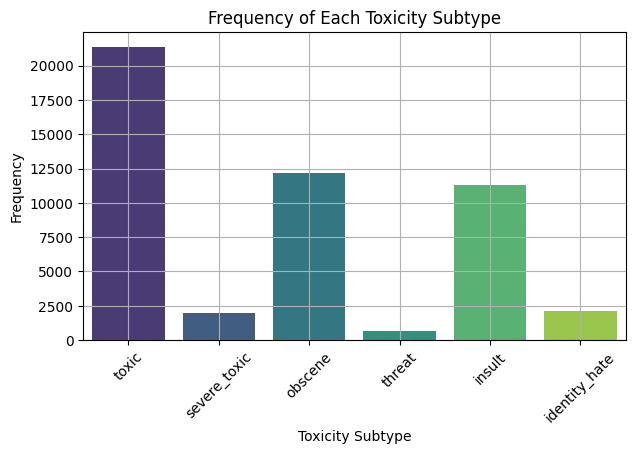

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not

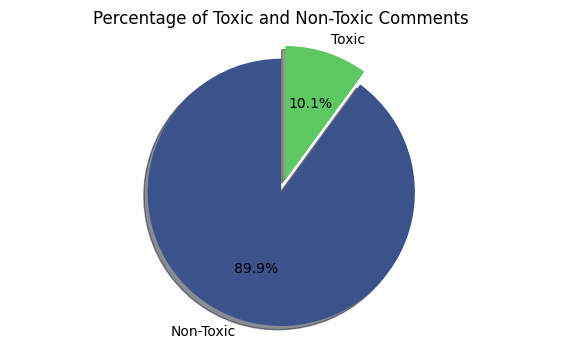

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not

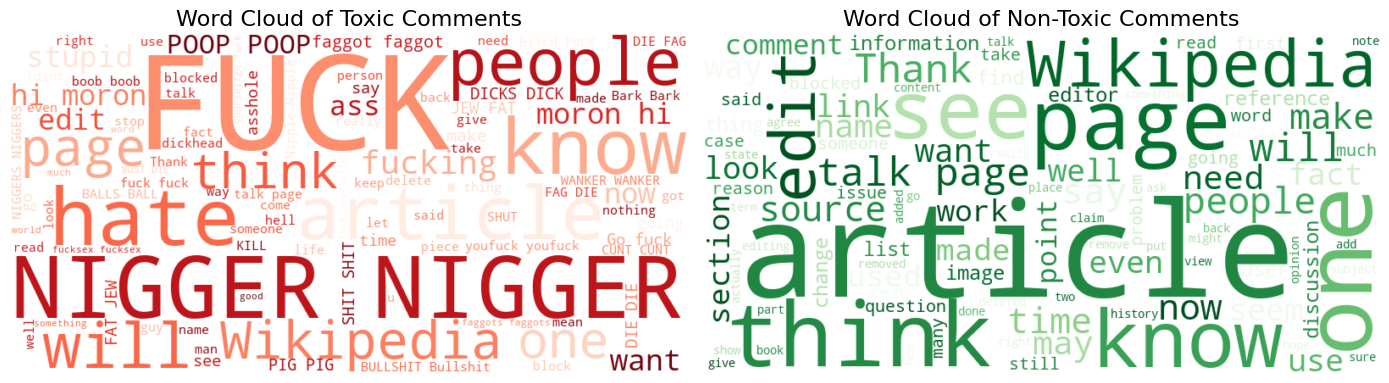

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_toxic', y='comment_length', palette='viridis', ax=axes[1])
/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=toxicity_avg_length, x='is_toxic', y='comment_length', palette='viridis', ax=axes[2])


Plots saved to comment_len_jigsaw


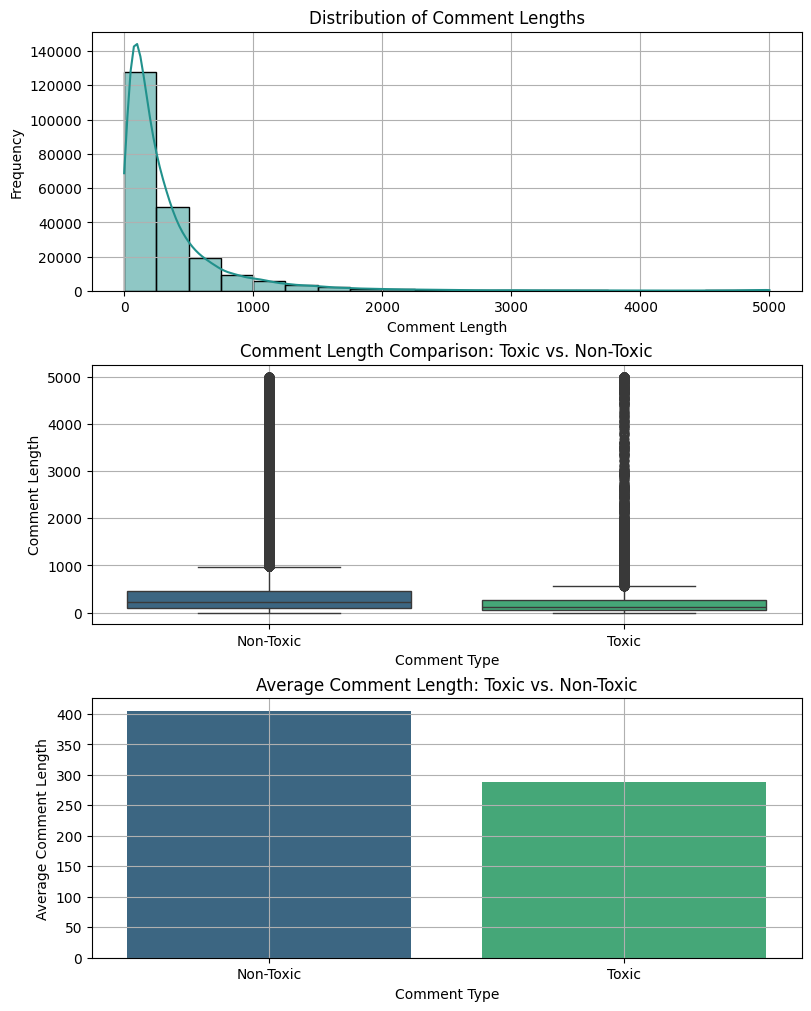

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not

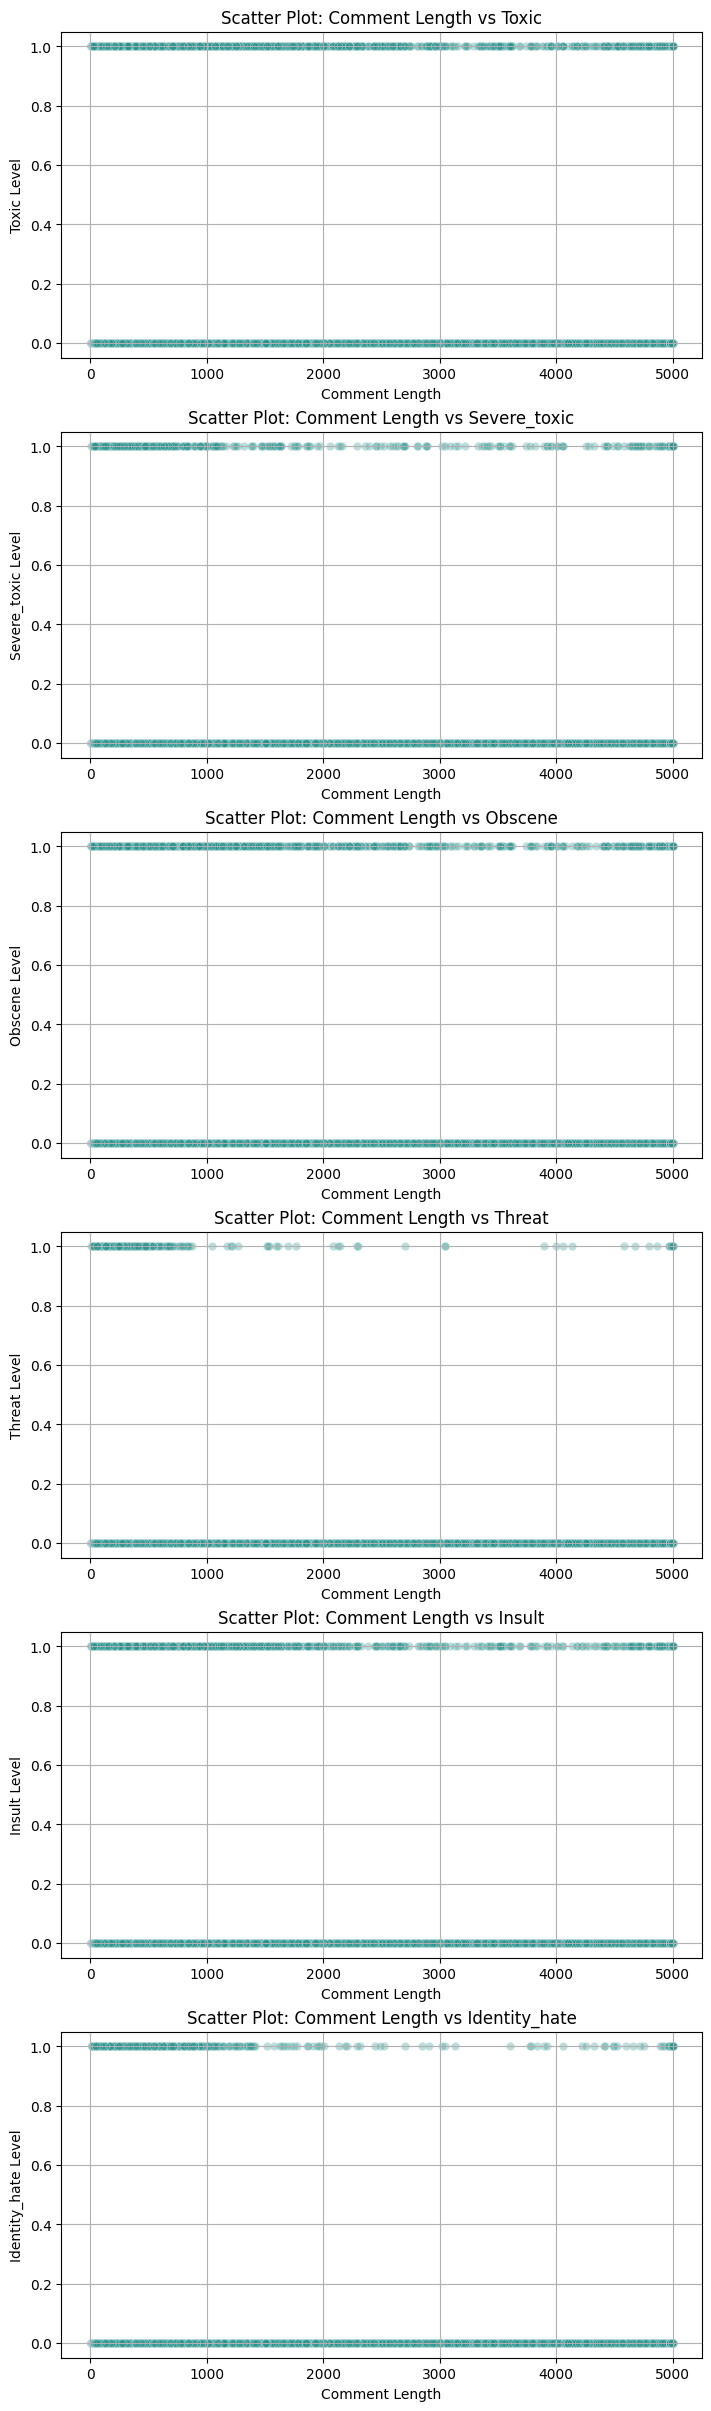

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223549 entries, 0 to 223548
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             223549 non-null  object
 1   comment_text   223549 non-null  object
 2   toxic          223549 non-null  int64 
 3   severe_toxic   223549 non-null  int64 
 4   obscene        223549 non-null  int64 
 5   threat         223549 non-null  int64 
 6   insult         223549 non-null  int64 
 7   identity_hate  223549 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 13.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[i])
/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[i])
/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palet

Plot saved to Word_frequency_jigsaw


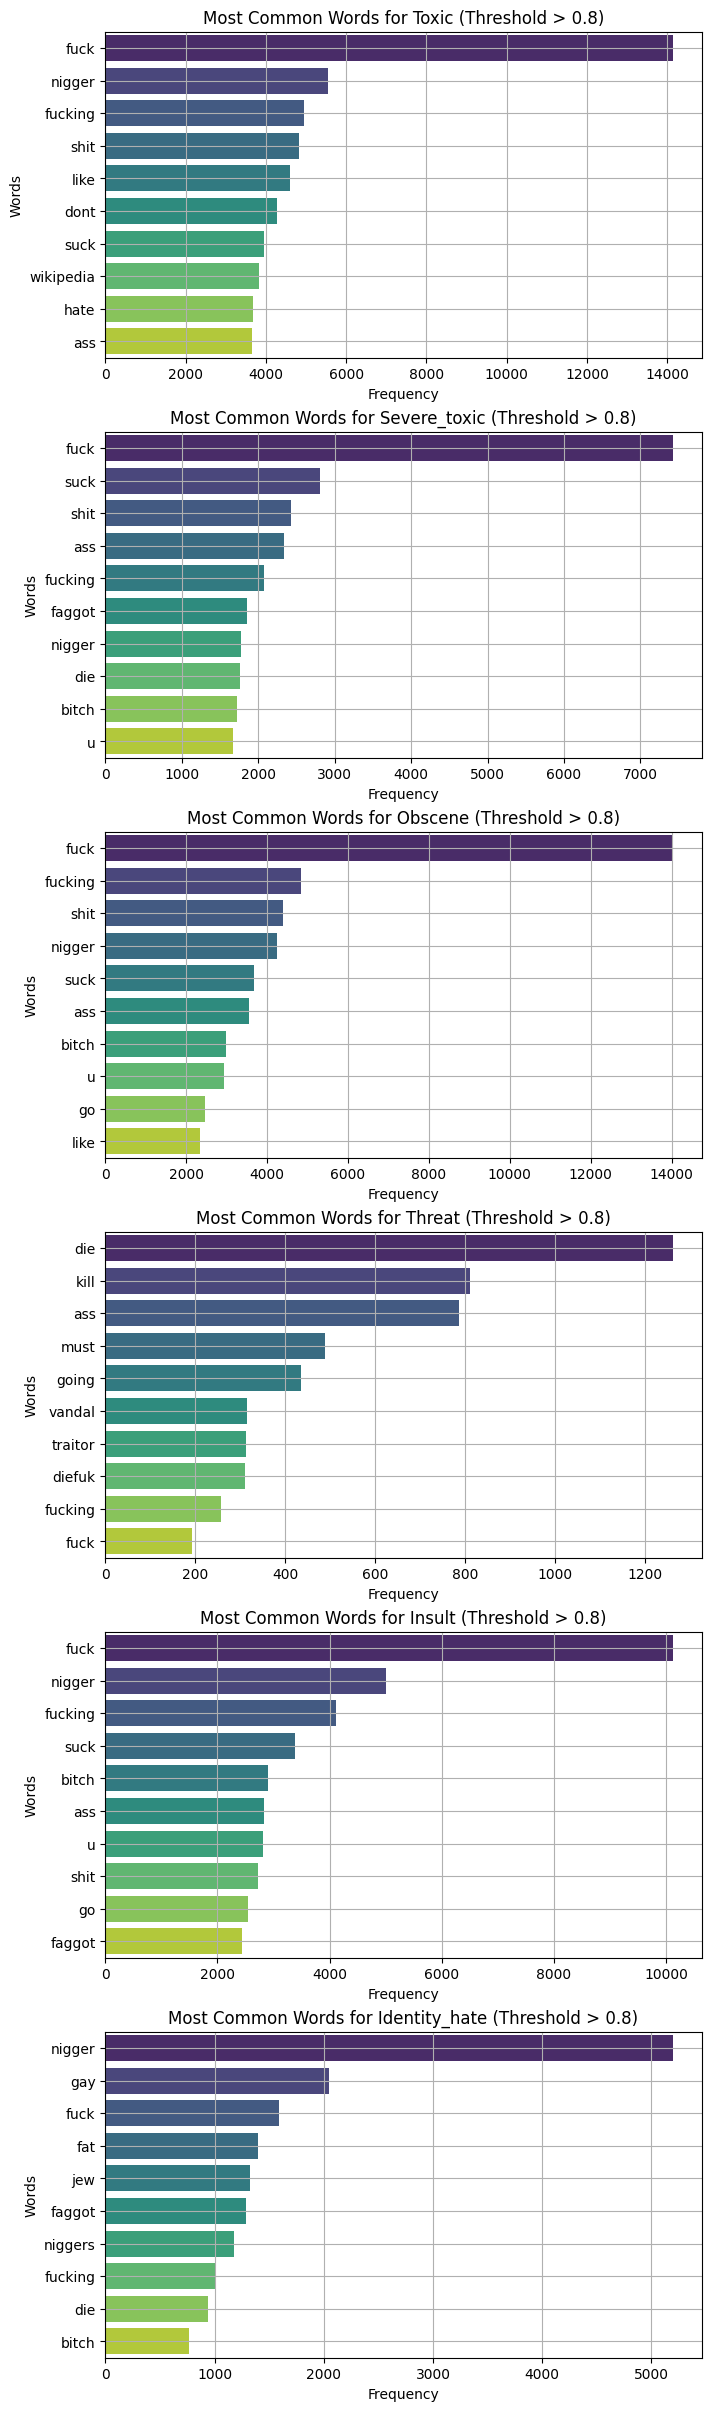

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999514 entries, 0 to 1999513
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   text             object 
 1   toxicity         float32
 2   severe_toxicity  float32
 3   obscene          float32
 4   threat           float32
 5   insult           float32
 6   identity_attack  float32
 7   sexual_explicit  float32
dtypes: float32(7), object(1)
memory usage: 68.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                                                text  toxicity  \
0  The last time I heard that a minority was prev...  0.000000   
1  The reason it's all Obama's fault is because h...  0.166667   
2  It's worth fearing decisions based off archaic...  0.000000   
3                                    Ineligible why?  0.000000   
4                              Do your own research.  0.000000   

   severe_toxicity  obscen

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=toxicity_columns, y=frequencies, palette="viridis")


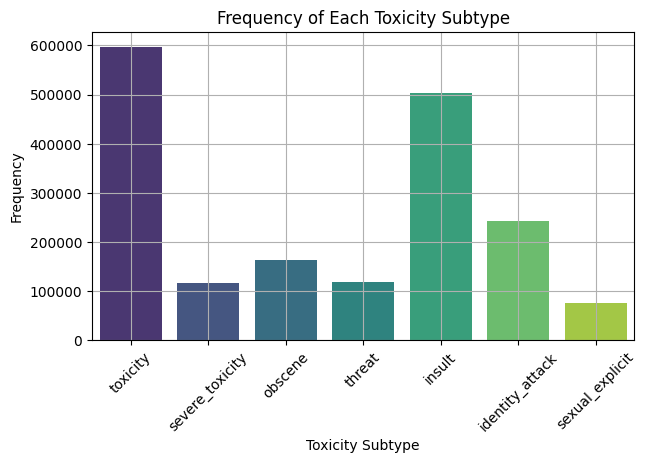

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999514 entries, 0 to 1999513
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   text             object 
 1   toxicity         float32
 2   severe_toxicity  float32
 3   obscene          float32
 4   threat           float32
 5   insult           float32
 6   identity_attack  float32
 7   sexual_explicit  float32
dtypes: float32(7), object(1)
memory usage: 68.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                                                text  toxicity  \
0  The last time I heard that a minority was prev...  0.000000   
1  The reason it's all Obama's fault is because h...  0.166667   
2  It's worth fearing decisions based off archaic...  0.000000   
3                                    Ineligible why?  0.000000   
4                              Do your own research.  0.000000   

   severe_toxicity  obscen

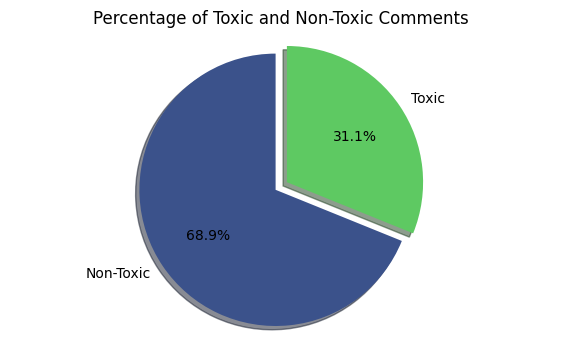

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999514 entries, 0 to 1999513
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   text             object 
 1   toxicity         float32
 2   severe_toxicity  float32
 3   obscene          float32
 4   threat           float32
 5   insult           float32
 6   identity_attack  float32
 7   sexual_explicit  float32
dtypes: float32(7), object(1)
memory usage: 68.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                                                text  toxicity  \
0  The last time I heard that a minority was prev...  0.000000   
1  The reason it's all Obama's fault is because h...  0.166667   
2  It's worth fearing decisions based off archaic...  0.000000   
3                                    Ineligible why?  0.000000   
4                              Do your own research.  0.000000   

   severe_toxicity  obscen

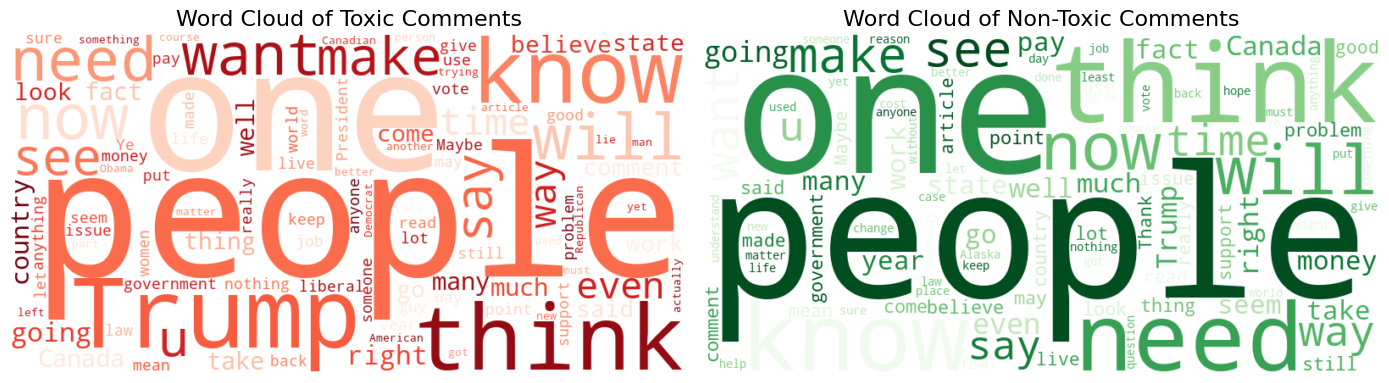

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999514 entries, 0 to 1999513
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   text             object 
 1   toxicity         float32
 2   severe_toxicity  float32
 3   obscene          float32
 4   threat           float32
 5   insult           float32
 6   identity_attack  float32
 7   sexual_explicit  float32
dtypes: float32(7), object(1)
memory usage: 68.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                                                text  toxicity  \
0  The last time I heard that a minority was prev...  0.000000   
1  The reason it's all Obama's fault is because h...  0.166667   
2  It's worth fearing decisions based off archaic...  0.000000   
3                                    Ineligible why?  0.000000   
4                              Do your own research.  0.000000   

   severe_toxicity  obscen

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_toxic', y='comment_length', palette='viridis', ax=axes[1])
/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=toxicity_avg_length, x='is_toxic', y='comment_length', palette='viridis', ax=axes[2])


Plots saved to comment_len_cc


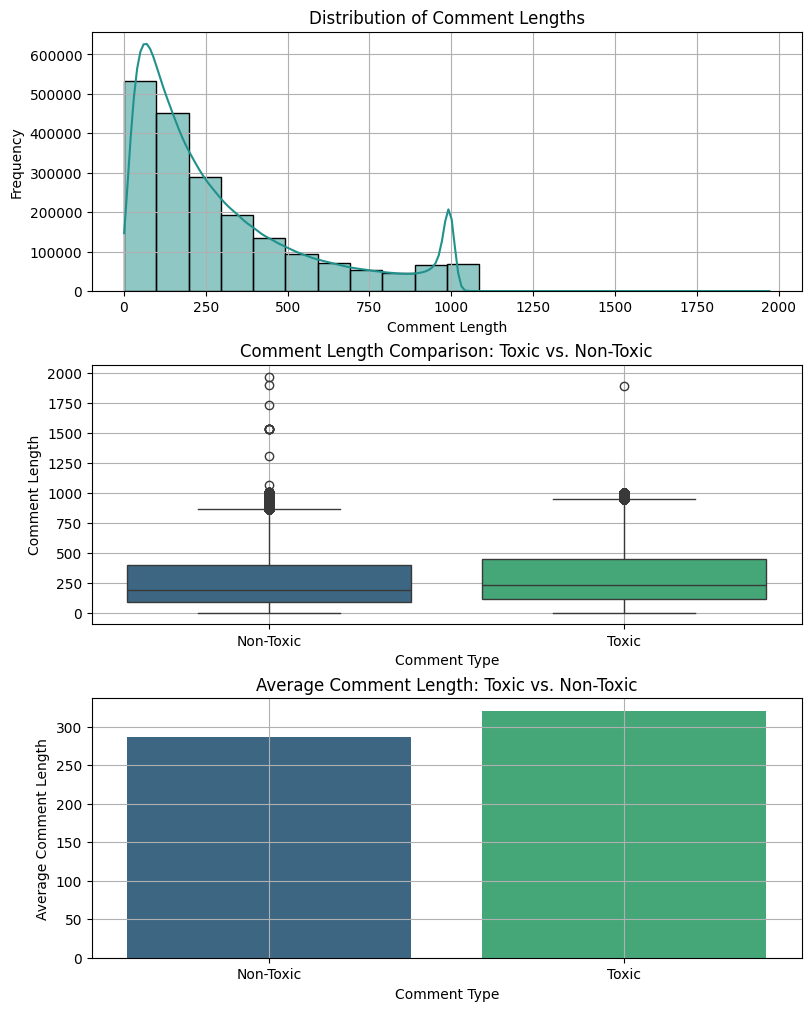

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999514 entries, 0 to 1999513
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   text             object 
 1   toxicity         float32
 2   severe_toxicity  float32
 3   obscene          float32
 4   threat           float32
 5   insult           float32
 6   identity_attack  float32
 7   sexual_explicit  float32
dtypes: float32(7), object(1)
memory usage: 68.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                                                text  toxicity  \
0  The last time I heard that a minority was prev...  0.000000   
1  The reason it's all Obama's fault is because h...  0.166667   
2  It's worth fearing decisions based off archaic...  0.000000   
3                                    Ineligible why?  0.000000   
4                              Do your own research.  0.000000   

   severe_toxicity  obscen

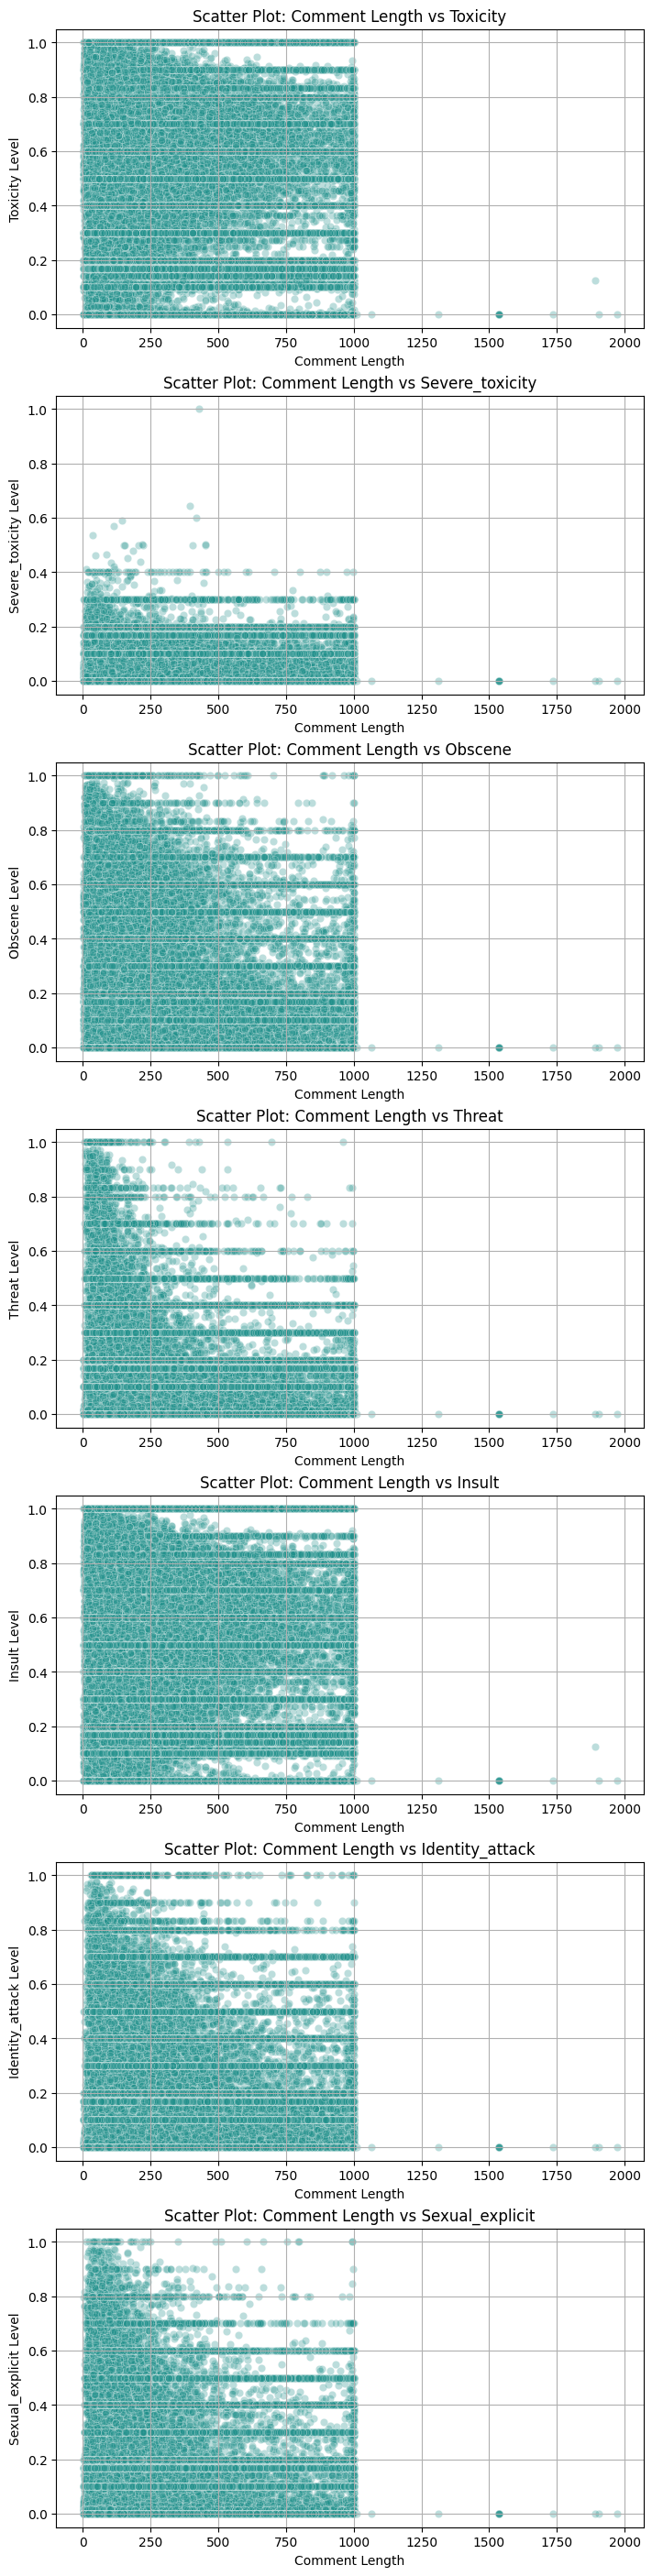

Dataset info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999514 entries, 0 to 1999513
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   text             object 
 1   toxicity         float32
 2   severe_toxicity  float32
 3   obscene          float32
 4   threat           float32
 5   insult           float32
 6   identity_attack  float32
 7   sexual_explicit  float32
dtypes: float32(7), object(1)
memory usage: 68.6+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
                                                text  toxicity  \
0  The last time I heard that a minority was prev...  0.000000   
1  The reason it's all Obama's fault is because h...  0.166667   
2  It's worth fearing decisions based off archaic...  0.000000   
3                                    Ineligible why?  0.000000   
4                              Do your own research.  0.000000   

   severe_toxicity  obscen

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[i])
/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[i])
/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/1559455637.py:264: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palet

Plot saved to Word_Frequency_cc


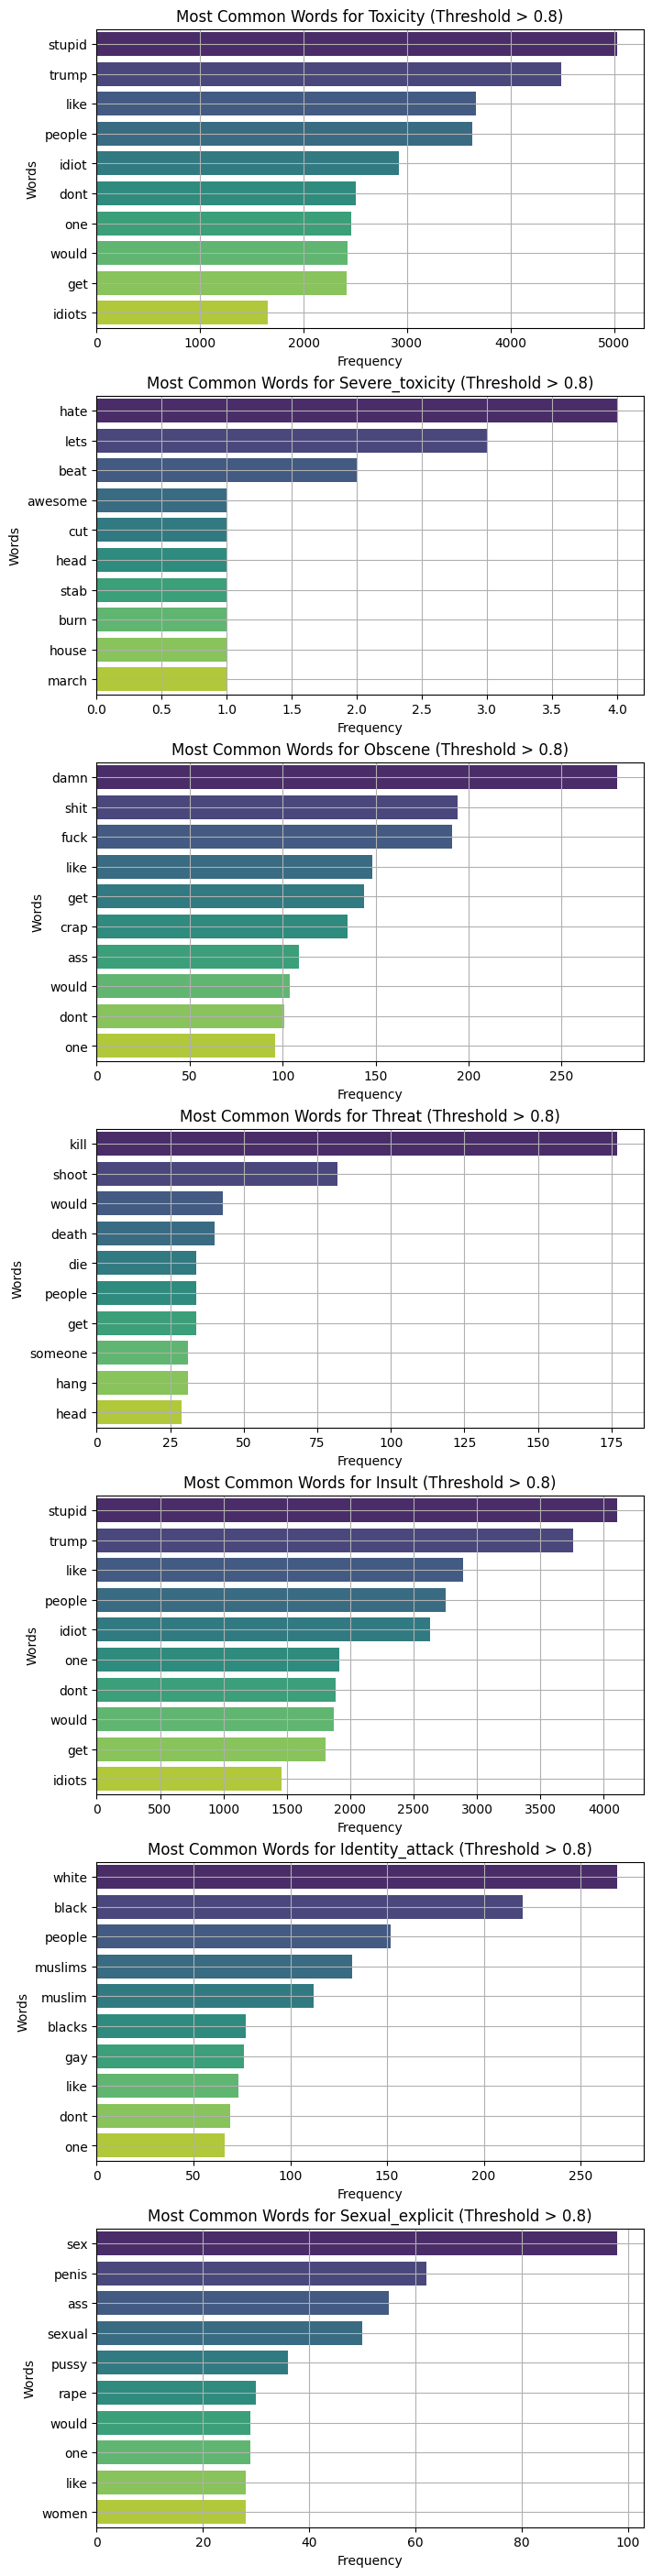

Number of hidden labels in the dataset: 1821
Dataset info: 
<class 'pandas.core.frame.DataFrame'>
Index: 68221 entries, 0 to 70041
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   idx       68221 non-null  int32 
 1   sentence  68221 non-null  object
 2   label     68221 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.8+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
     idx                                           sentence  label
0  50989  mazel tov to a film about a family 's joyous l...      1
1  43922                                 a subzero version       0
2  49814                 by the sheer beauty of his images       1
3  29277  ( f ) rom the performances and the cinematogra...      1
4  35821                                          monotony       0
----------------------------------------------------------------
Visualization saved to 

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/483813700.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


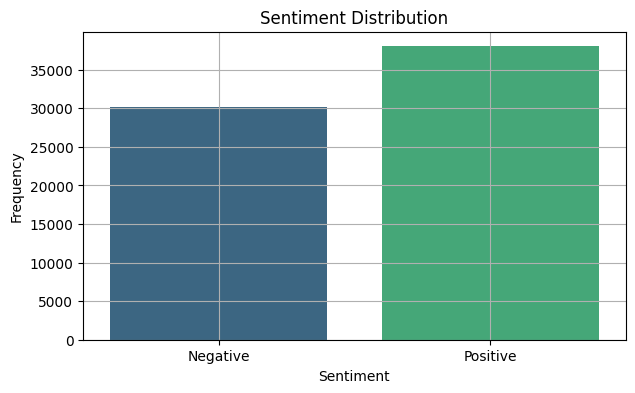

Number of hidden labels in the dataset: 1821
Dataset info: 
<class 'pandas.core.frame.DataFrame'>
Index: 68221 entries, 0 to 70041
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   idx       68221 non-null  int32 
 1   sentence  68221 non-null  object
 2   label     68221 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.8+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
     idx                                           sentence  label
0  50989  mazel tov to a film about a family 's joyous l...      1
1  43922                                 a subzero version       0
2  49814                 by the sheer beauty of his images       1
3  29277  ( f ) rom the performances and the cinematogra...      1
4  35821                                          monotony       0
----------------------------------------------------------------
Visualization saved to 

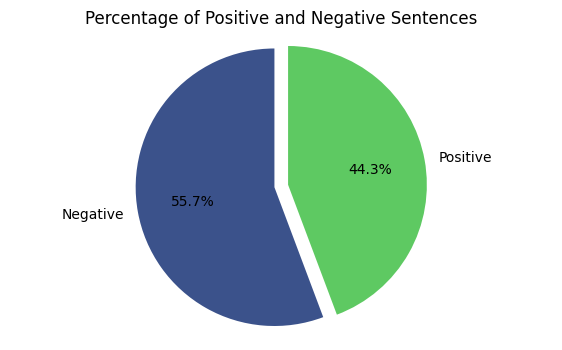

Number of hidden labels in the dataset: 1821
Dataset info: 
<class 'pandas.core.frame.DataFrame'>
Index: 68221 entries, 0 to 70041
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   idx       68221 non-null  int32 
 1   sentence  68221 non-null  object
 2   label     68221 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.8+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
     idx                                           sentence  label
0  50989  mazel tov to a film about a family 's joyous l...      1
1  43922                                 a subzero version       0
2  49814                 by the sheer beauty of his images       1
3  29277  ( f ) rom the performances and the cinematogra...      1
4  35821                                          monotony       0
----------------------------------------------------------------
Visualization saved to 

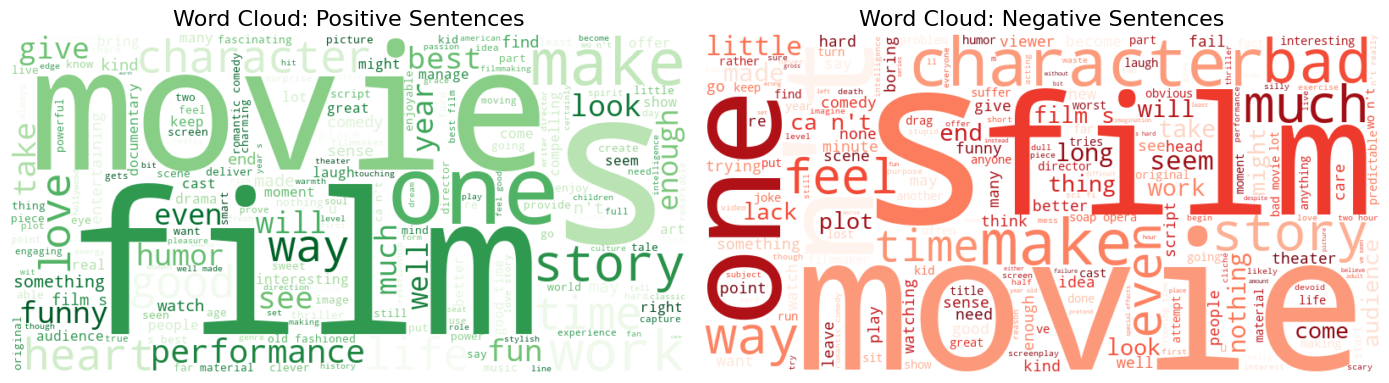

Number of hidden labels in the dataset: 1821
Dataset info: 
<class 'pandas.core.frame.DataFrame'>
Index: 68221 entries, 0 to 70041
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   idx       68221 non-null  int32 
 1   sentence  68221 non-null  object
 2   label     68221 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.8+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
     idx                                           sentence  label
0  50989  mazel tov to a film about a family 's joyous l...      1
1  43922                                 a subzero version       0
2  49814                 by the sheer beauty of his images       1
3  29277  ( f ) rom the performances and the cinematogra...      1
4  35821                                          monotony       0
----------------------------------------------------------------
Visualization saved to 

/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/483813700.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_length, x='label', y='sentence_length', palette='viridis')


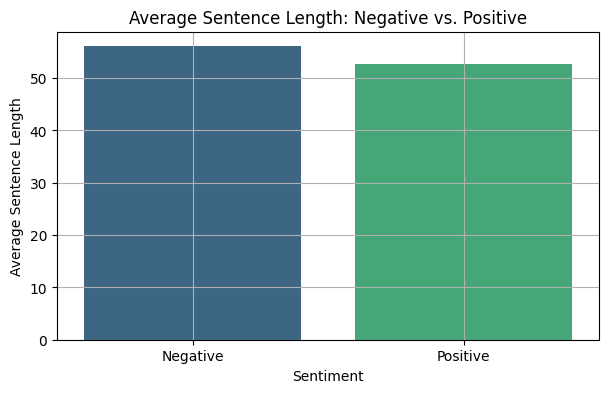

Number of hidden labels in the dataset: 1821
Dataset info: 
<class 'pandas.core.frame.DataFrame'>
Index: 68221 entries, 0 to 70041
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   idx       68221 non-null  int32 
 1   sentence  68221 non-null  object
 2   label     68221 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 1.8+ MB
----------------------------------------------------------------

 First 5 rows of the dataset: 
     idx                                           sentence  label
0  50989  mazel tov to a film about a family 's joyous l...      1
1  43922                                 a subzero version       0
2  49814                 by the sheer beauty of his images       1
3  29277  ( f ) rom the performances and the cinematogra...      1
4  35821                                          monotony       0
----------------------------------------------------------------


/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/483813700.py:213: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[i])
/var/folders/1m/1wt5d5154bg4twk9y67kbx3w0000gn/T/ipykernel_9716/483813700.py:213: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis', ax=axes[i])


Plot saved to Word_frequency_sst2


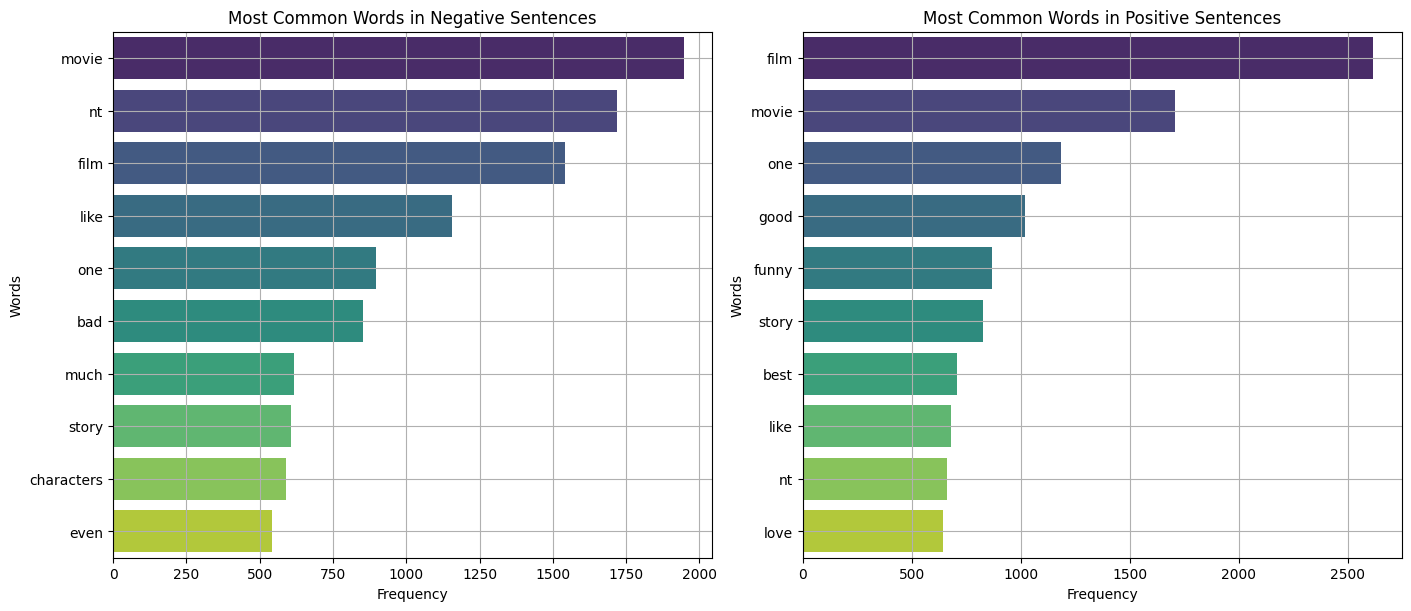

In [13]:
# Example plots
# Note: Running the following lines will print the dataset info many times, as the show() function is intented to be run only once for 
# a plot at a time

show('toxicity_frequency', outfile="Toxicity_frequency_Jigsaw", dataset="Jigsaw")
show('toxicity_percentage', outfile="Toxicity_percentage_Jigsaw", dataset="Jigsaw")
show('wordclouds', outfile="wordclouds_jigsaw", dataset="Jigsaw")
show('comment_length_analysis', outfile="comment_len_jigsaw", dataset="Jigsaw")
show('toxicity_vs_length', outfile="toxicity_length_jigsaw", dataset="Jigsaw")
show('word_frequency', outfile='Word_frequency_jigsaw', dataset="Jigsaw")    
     
show('toxicity_frequency', outfile="Toxicity_frequency_cc", dataset="civil_comments")
show('toxicity_percentage', outfile="Toxicity_percentage_cc", dataset="civil_comments")
show('wordclouds', outfile="wordclouds_cc", dataset="civil_comments")
show('comment_length_analysis', outfile="comment_len_cc", dataset="civil_comments")
show('toxicity_vs_length', outfile="toxicity_length_cc", dataset="civil_comments")
show('word_frequency', outfile='Word_Frequency_cc', dataset="civil_comments")

show('sentiment_frequency', outfile="sentiment_frequency", dataset="SST2")
show('sentiment_percentage', outfile="sentiment_percentage", dataset="SST2")
show('wordclouds', outfile="wordclouds_SST2", dataset="SST2")
show('avg_sentence_length', outfile='avg_sentence_length', dataset="SST2")
show('word_frequency', outfile='Word_frequency_sst2', dataset="SST2")
